# Project 2:    Melanoma Classification

# Abstract
---
### Purpose of research
1. Analyse and classify Melanoma datasets, including metadata and image datasets), which are provided on Kaggle plateform https://www.kaggle.com/c/siim-isic-melanoma-classification
2. find the best algorithm to build module and predict the probability of condition of Melanoma (benign or malignant) based on test metadata and images.
3. the result is evaluated on AOC (area under the ROC curve) between the predicted probability and the observed target.

### Working procedure
1. EDA
2. Data Preprocessing
3. Model build
4. Training Tuning, and predicting

### Summary of findings
1. Three out of five economic indicators - features - are strongly correlative with people's incomes (Average hourly earnings), namely GDP, Population and CPI. On the contrary, House Price Index and Unemployment rate have an insignificant effect on Average hourly earnings.
2. CPI has the larges impact on Average hourly earnings, followed by Population and GDP. 
3. **Using all the three features (GDP, Population and CPI) to generate Linear Regression will get a more plausible prediction than using single feature**.
4. When Using all the three features to generate predictions model, **Linear Regression is more reliable for prediction than kNN and Random Forest Regressor**.
5. kNN and Random Forest are not suitable for this Time Series dataset, and **normalisation is not of little value for this datasets**.
6. The reason for the 5th conclusion is stated as follow: the Average hourly earnings is constantly increasing over time, any new data will be out of the previous data range, thus it is unpredictable by the existing neighbours, regardless of normalisation.

# Introduction
It is an interesting topic to find out which economic indicators determine or at least significantly impact ordinary people's incomes. Definitely, some factors will affect ordinary people's earnings and make a difference from person to person. Those factors include educational degree, work experience, soft power, opportunity, industry and so on. Those factors could be considered as "Micro-levels", however, if we want to evaluate people's incomes between nations, what need to take into account will be some "Macro" circumstances, such as national Gross Domestic Product (GDP), Consumer Price Index (CPI), Population, etc. The common indicator will be a country's Average hourly earnings or some other similar "average" indicators when all the residences are observed as a whole.

In this notebook, New Zealand's Average hourly earnings will be estimated at a Macro-level while five national economic indicators will be used as predictors, namely GDP, Population, CPI, Unemployment rate and House Price Index. We will try to identify which predictive elements are the most important ones when predicting Average hourly earnings. Some regression models will be tested to find the best model for future prediction.

# Methodology

## Environment Preparation

In [135]:
#header information
__author__ = 'Joshua Xu'
__version__ = "1.0.0"
__maintainer__ = "Joshua Xu"

In [157]:
%matplotlib inline
# imports
import requests                 # How Python gets the webpages
from bs4 import BeautifulSoup   # Creates structured, searchable object
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import json
from pandas_datareader import data #this lib is used to acquire data in this notebook
import pprint as pp
from datetime import datetime

In [158]:
from pylab import rcParams
sns.set(style="ticks")
#sns.set_style("whitegrid")
rcParams['figure.dpi'] = 180
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10

## Data Acquiring

In [138]:
#get data from url with xml format and return a string 
def get_scrap(url):
    response = requests.get(url)
    if response.status_code != 200:
        print("cannot get the page, check the Internet Connection!")
        return EOFError
    else:
        page = response.content
        scraping = BeautifulSoup(page, "lxml")
        return scraping

In [139]:
#get data from url with json format and return a dictionary 
def get_json(url):
    response = requests.get(url)
    if response.status_code != 200:
        print("cannot get the page, check the Internet Connection!")
        return EOFError
    else:
        page = response.content
        dict_content = json.loads(page)
        return dict_content

In [7]:
query = "&".join(['dataset=RBNZ_HOUSE',
                 'h=TIME',
                 'v=Indicator',
                 'format=json'
                 ])
url = f"https://www.econdb.com/api/series/?{query}"
house_dict = get_json(url)

In [137]:
#acquire house price index data via API 
house_index_table = pd.DataFrame(house_dict.get('results')[1].get('data'))
house_index_table.set_index('dates', inplace=True)
house_index_table = house_index_table[['values']]['2000-01-01':]
house_index_table.columns = ['House Price Index']
house_index_table.head()

,House Price Index
dates,
2000-01-01,2707
2000-04-01,2299
2000-07-01,2386
2000-10-01,2099
2001-01-01,1848


In [140]:
# using DataReader to acquire GDP data, return a DataFrame
gdp_table = data.DataReader('ticker=NZ_GDP.SNEQ_SG00RAC00B06.Q.NZ', 'econdb', start="2000-01-01")
gdp_table.head()

Indicator,Disposable Income - gross
Frequency,Quarterly
Units,Million NZD
Subject,National Accounts - SNA 2008 - SNE
Group,"Series, Key aggregates, Chain volume, Actual, Total"
Series_title_1,Disposable Income - gross
TIME_PERIOD,
2000-01-01,34034
2000-04-01,34053
2000-07-01,34649
2000-10-01,36806


In [149]:
gdp_table.columns = ['GDP']
gdp_table = gdp_table.rename_axis("dates")

In [150]:
# get population, unemployment rate, CPI via DataReader
pop_table = data.DataReader('ticker=RBNZ_POP.PNA.Q.NZ', 'econdb', start="2000-01-01")
unemply_table = data.DataReader('ticker=RBNZ_LABOUR.L06G001NS.Q.NZ', 'econdb', start="2000-01-01")
AHE_table = data.DataReader('ticker=RBNZ_LABOUR.E03S0NA.Q.NZ', 'econdb', start="2000-01-01")
CPI_table = data.DataReader("ticker=CPINZ", "econdb", start="2000-01-01")
pp.pprint(pop_table.head())
pp.pprint(unemply_table.head())
pp.pprint(AHE_table.head())
pp.pprint(CPI_table.head())

Indicator   Estimated resident \npopulation - (Number)
Units                                               no
TIME_PERIOD                                           
2000-01-01                                     3855900
2000-04-01                                     3857700
2000-07-01                                     3864900
2000-10-01                                     3873100
2001-01-01                                     3876200
Indicator   Unemployment rate - (% s.a.)
Units                                  %
TIME_PERIOD                             
2000-01-01                           6.5
2000-04-01                           6.3
2000-07-01                           6.0
2000-10-01                           5.8
2001-01-01                           5.5
Indicator   Average hourly earnings (ordinary time and overtime) - ($)
Units                                                              ($)
TIME_PERIOD                                                           
2000-01-01         

In [151]:
pop_table.columns = ['Population']
unemply_table.columns = ['Unemployment rate']
AHE_table.columns = ['Average hourly earnings']
CPI_table.columns = ['CPI']

In [152]:
# merge all the tables together, return a DataFrame
economy_table = gdp_table.join([pop_table, house_index_table, CPI_table, unemply_table, AHE_table])
print(economy_table.info())
economy_table.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80 entries, 2000-01-01 to 2019-10-01
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   GDP                      80 non-null     int64  
 1   Population               80 non-null     int64  
 2   House Price Index        80 non-null     int64  
 3   CPI                      79 non-null     float64
 4   Unemployment rate        80 non-null     float64
 5   Average hourly earnings  80 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 6.9 KB
None


,GDP,Population,House Price Index,CPI,Unemployment rate,Average hourly earnings
dates,,,,,,
2018-10-01,66341,4881300,3979,1026.0,4.3,31.70
2019-01-01,63102,4904100,3942,1027.0,4.1,32.04
2019-04-01,62392,4914400,3994,1032.0,4.0,32.42
2019-07-01,63829,4934800,4041,1037.0,4.1,32.71
2019-10-01,68786,4951500,4148,NaN,4.0,32.83


### Filling Missed data 

As the Dataframe info function shows, there is one and only one missing value in CPI, and it is clear that the latest CPI, the CPI of the fourth quarter of 2019, is not available at the moment. In this case, it is reasonable to fill the missing value with the max value of the column because the CPI seems in ascending order.

In [153]:
economy_table.CPI.fillna(np.max(economy_table['CPI']), inplace=True)
economy_table.index = pd.to_datetime(economy_table.index)
economy_table.describe()

,GDP,Population,House Price Index,CPI,Unemployment rate,Average hourly earnings
count,80.000000,8.000000e+01,80.000000,80.000000,80.000000,80.000000
mean,48743.937500,4.348351e+06,2986.412500,880.600000,4.993750,24.940625
std,8693.672753,3.059497e+05,629.858728,108.233643,0.913658,4.534184
min,34034.000000,3.855900e+06,1848.000000,688.000000,3.300000,17.560000
25%,42929.750000,4.123525e+06,2416.750000,777.750000,4.100000,20.527500
50%,47532.500000,4.338900e+06,3005.500000,894.500000,5.050000,25.410000
75%,55060.250000,4.552825e+06,3383.500000,976.500000,5.725000,28.782500
max,68786.000000,4.951500e+06,4148.000000,1037.000000,6.700000,32.830000


## Data Analysis

### Correlation and Pairplot

In [154]:
economy_table.corr()

,GDP,Population,House Price Index,CPI,Unemployment rate,Average hourly earnings
GDP,1.000000,0.985274,0.743391,0.943909,-0.143050,0.965781
Population,0.985274,1.000000,0.707793,0.963495,-0.103244,0.984298
House Price Index,0.743391,0.707793,1.000000,0.551538,-0.497242,0.611616
CPI,0.943909,0.963495,0.551538,1.000000,0.065257,0.992984
Unemployment rate,-0.143050,-0.103244,-0.497242,0.065257,1.000000,0.016052
Average hourly earnings,0.965781,0.984298,0.611616,0.992984,0.016052,1.000000


It seems that three out of five features, namely "GDP", "Population" and "CPI", have a strong correlation with "Average hourly earnings" - the one which is used as a predictable scaler in this notebook. In addition, it seems that CPI has the closest relationship with "Average hourly earnings", and this is definitely not a very good news. It can be interpreted that the rise of income (represent by "Average hourly earnings") is primarily caused by the increasing CPI or so-called inflation. In other words, the wealth of ordinary people in New Zealand is not actually increased.

Now we may easily predict the "Average hourly earnings" with the three features. But first, let's have a look at the pair plot to get a more intuitive sense.

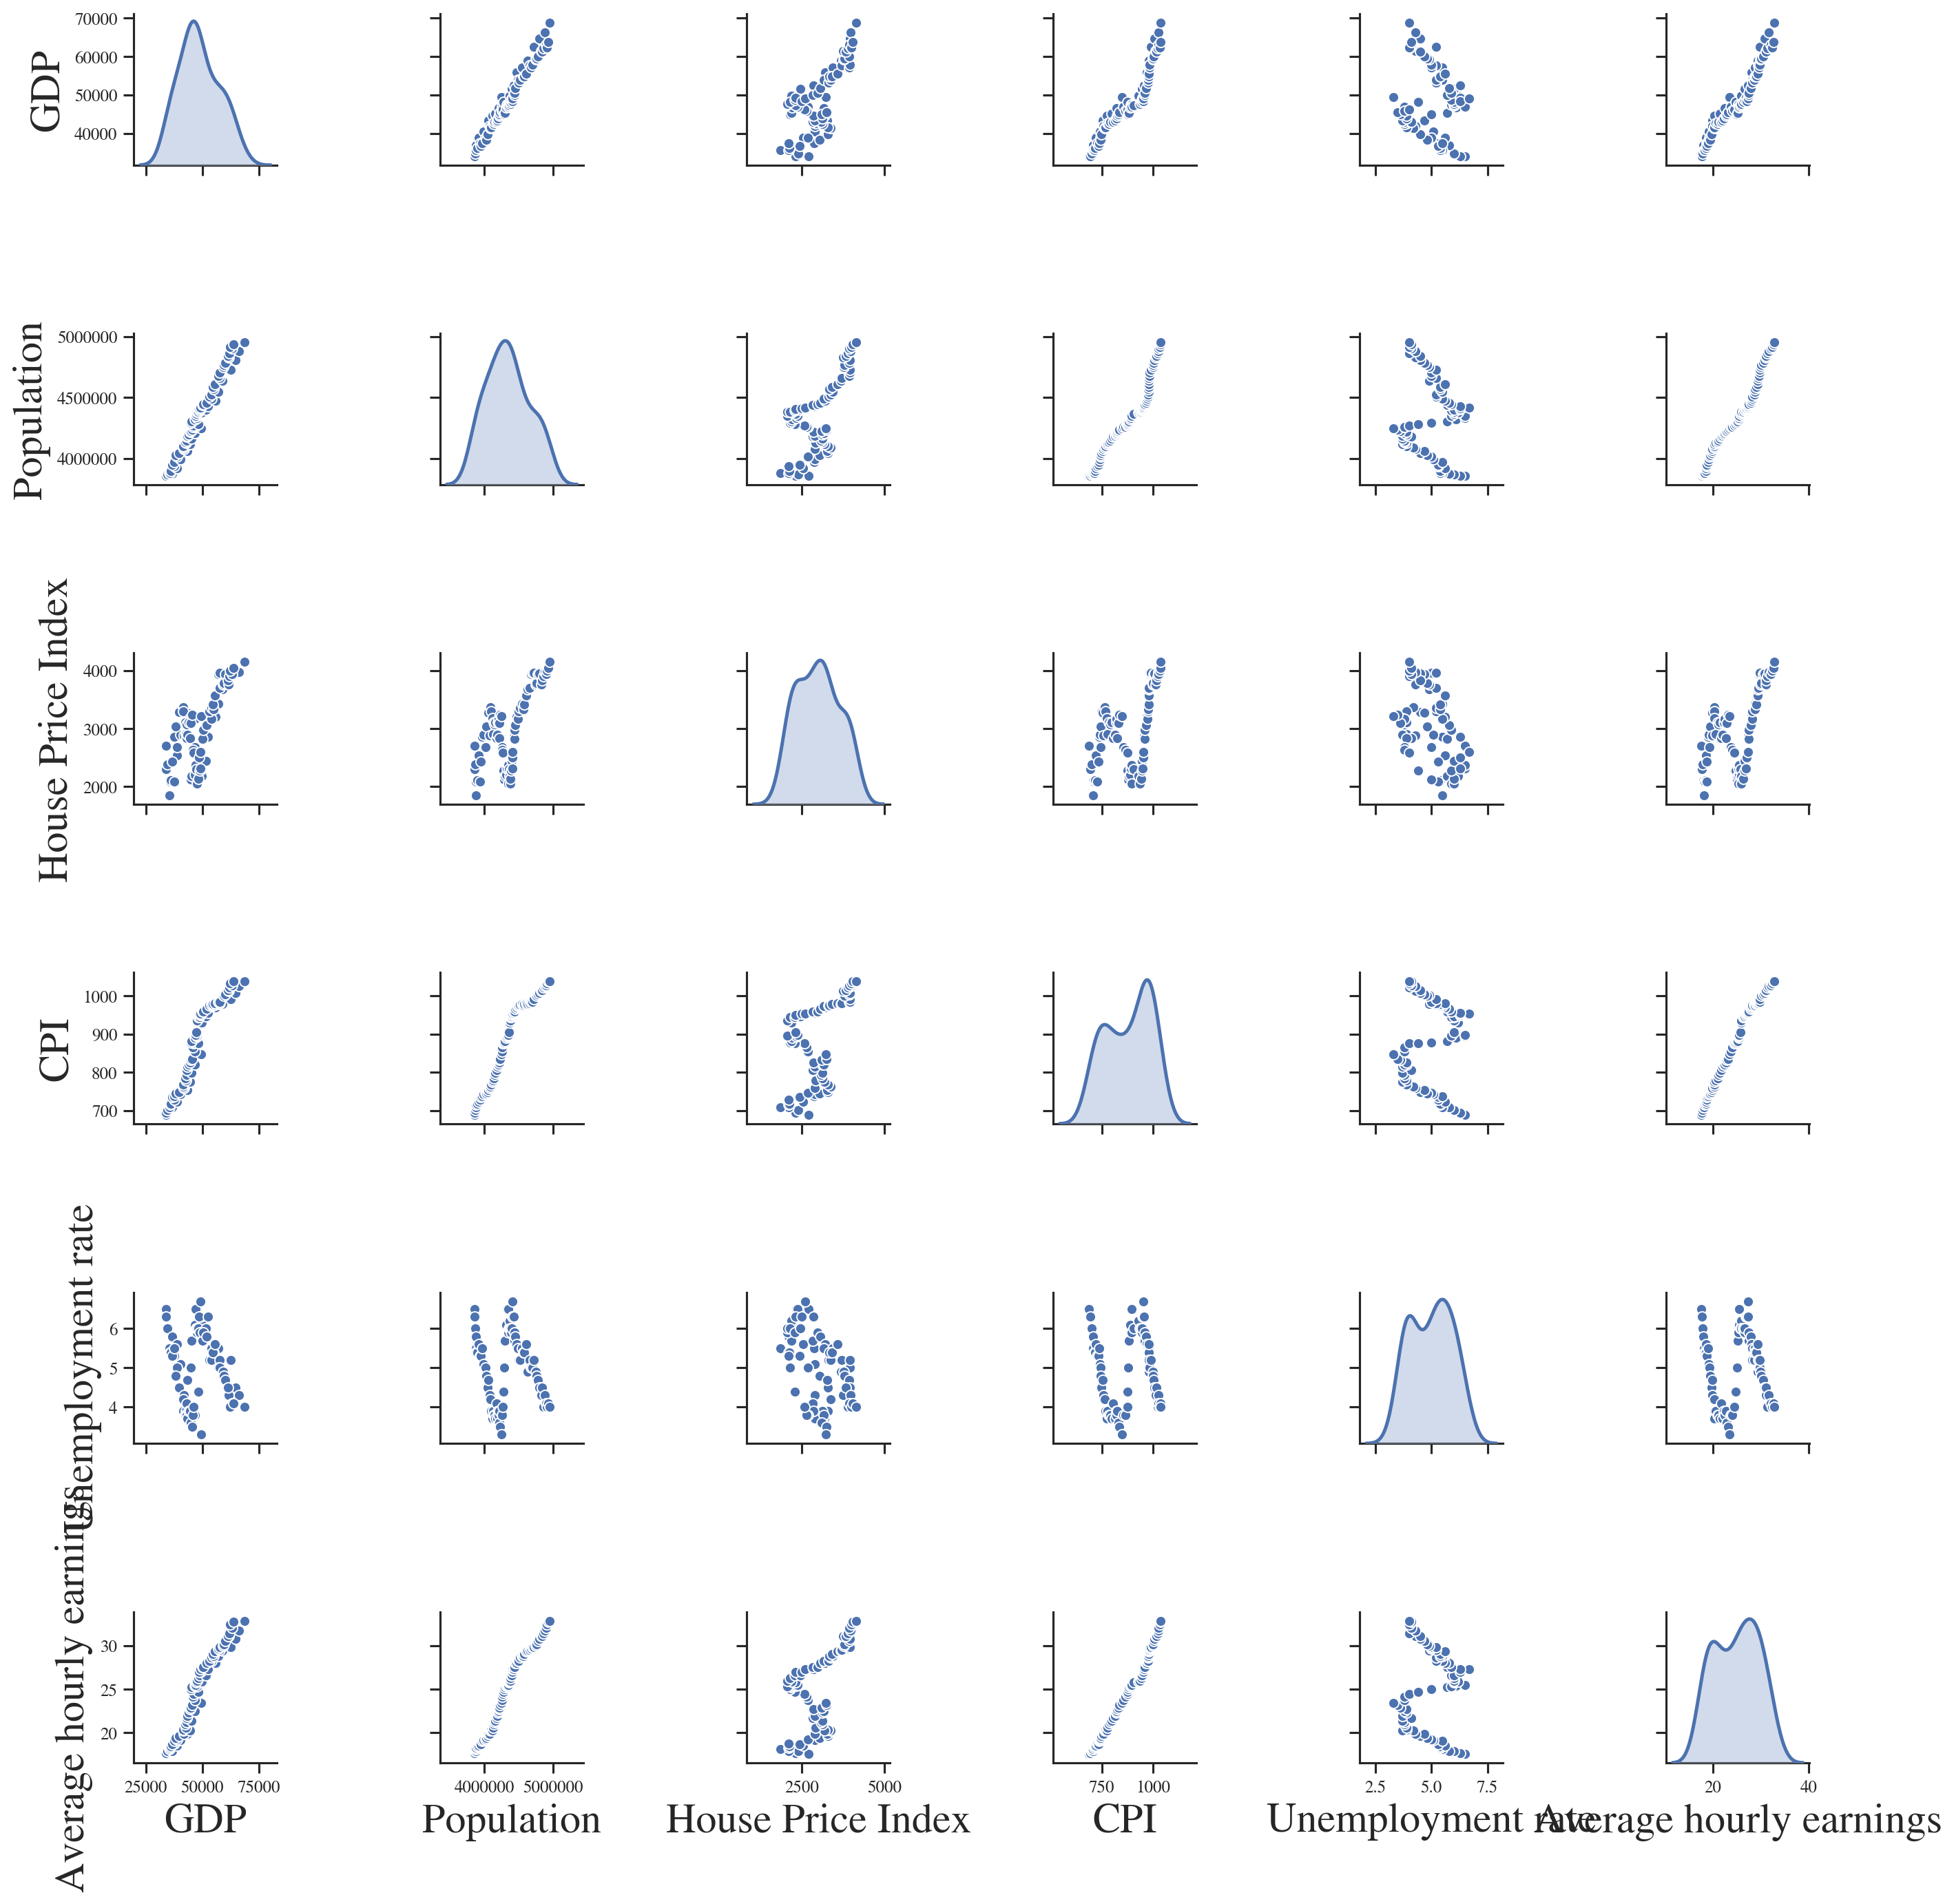

In [16]:
sns.pairplot(economy_table, diag_kind='kde')

Next, it is time to use some Machine Learning (ML) algorithms to analyse and predict our incomes - "Average hourly earnings". We will start by **Linear Regression**.

### Linear Regression

Let's plot and see regressions of the three most correlative features. Notice that we use all the data as training data, this would cause **overfitting**.

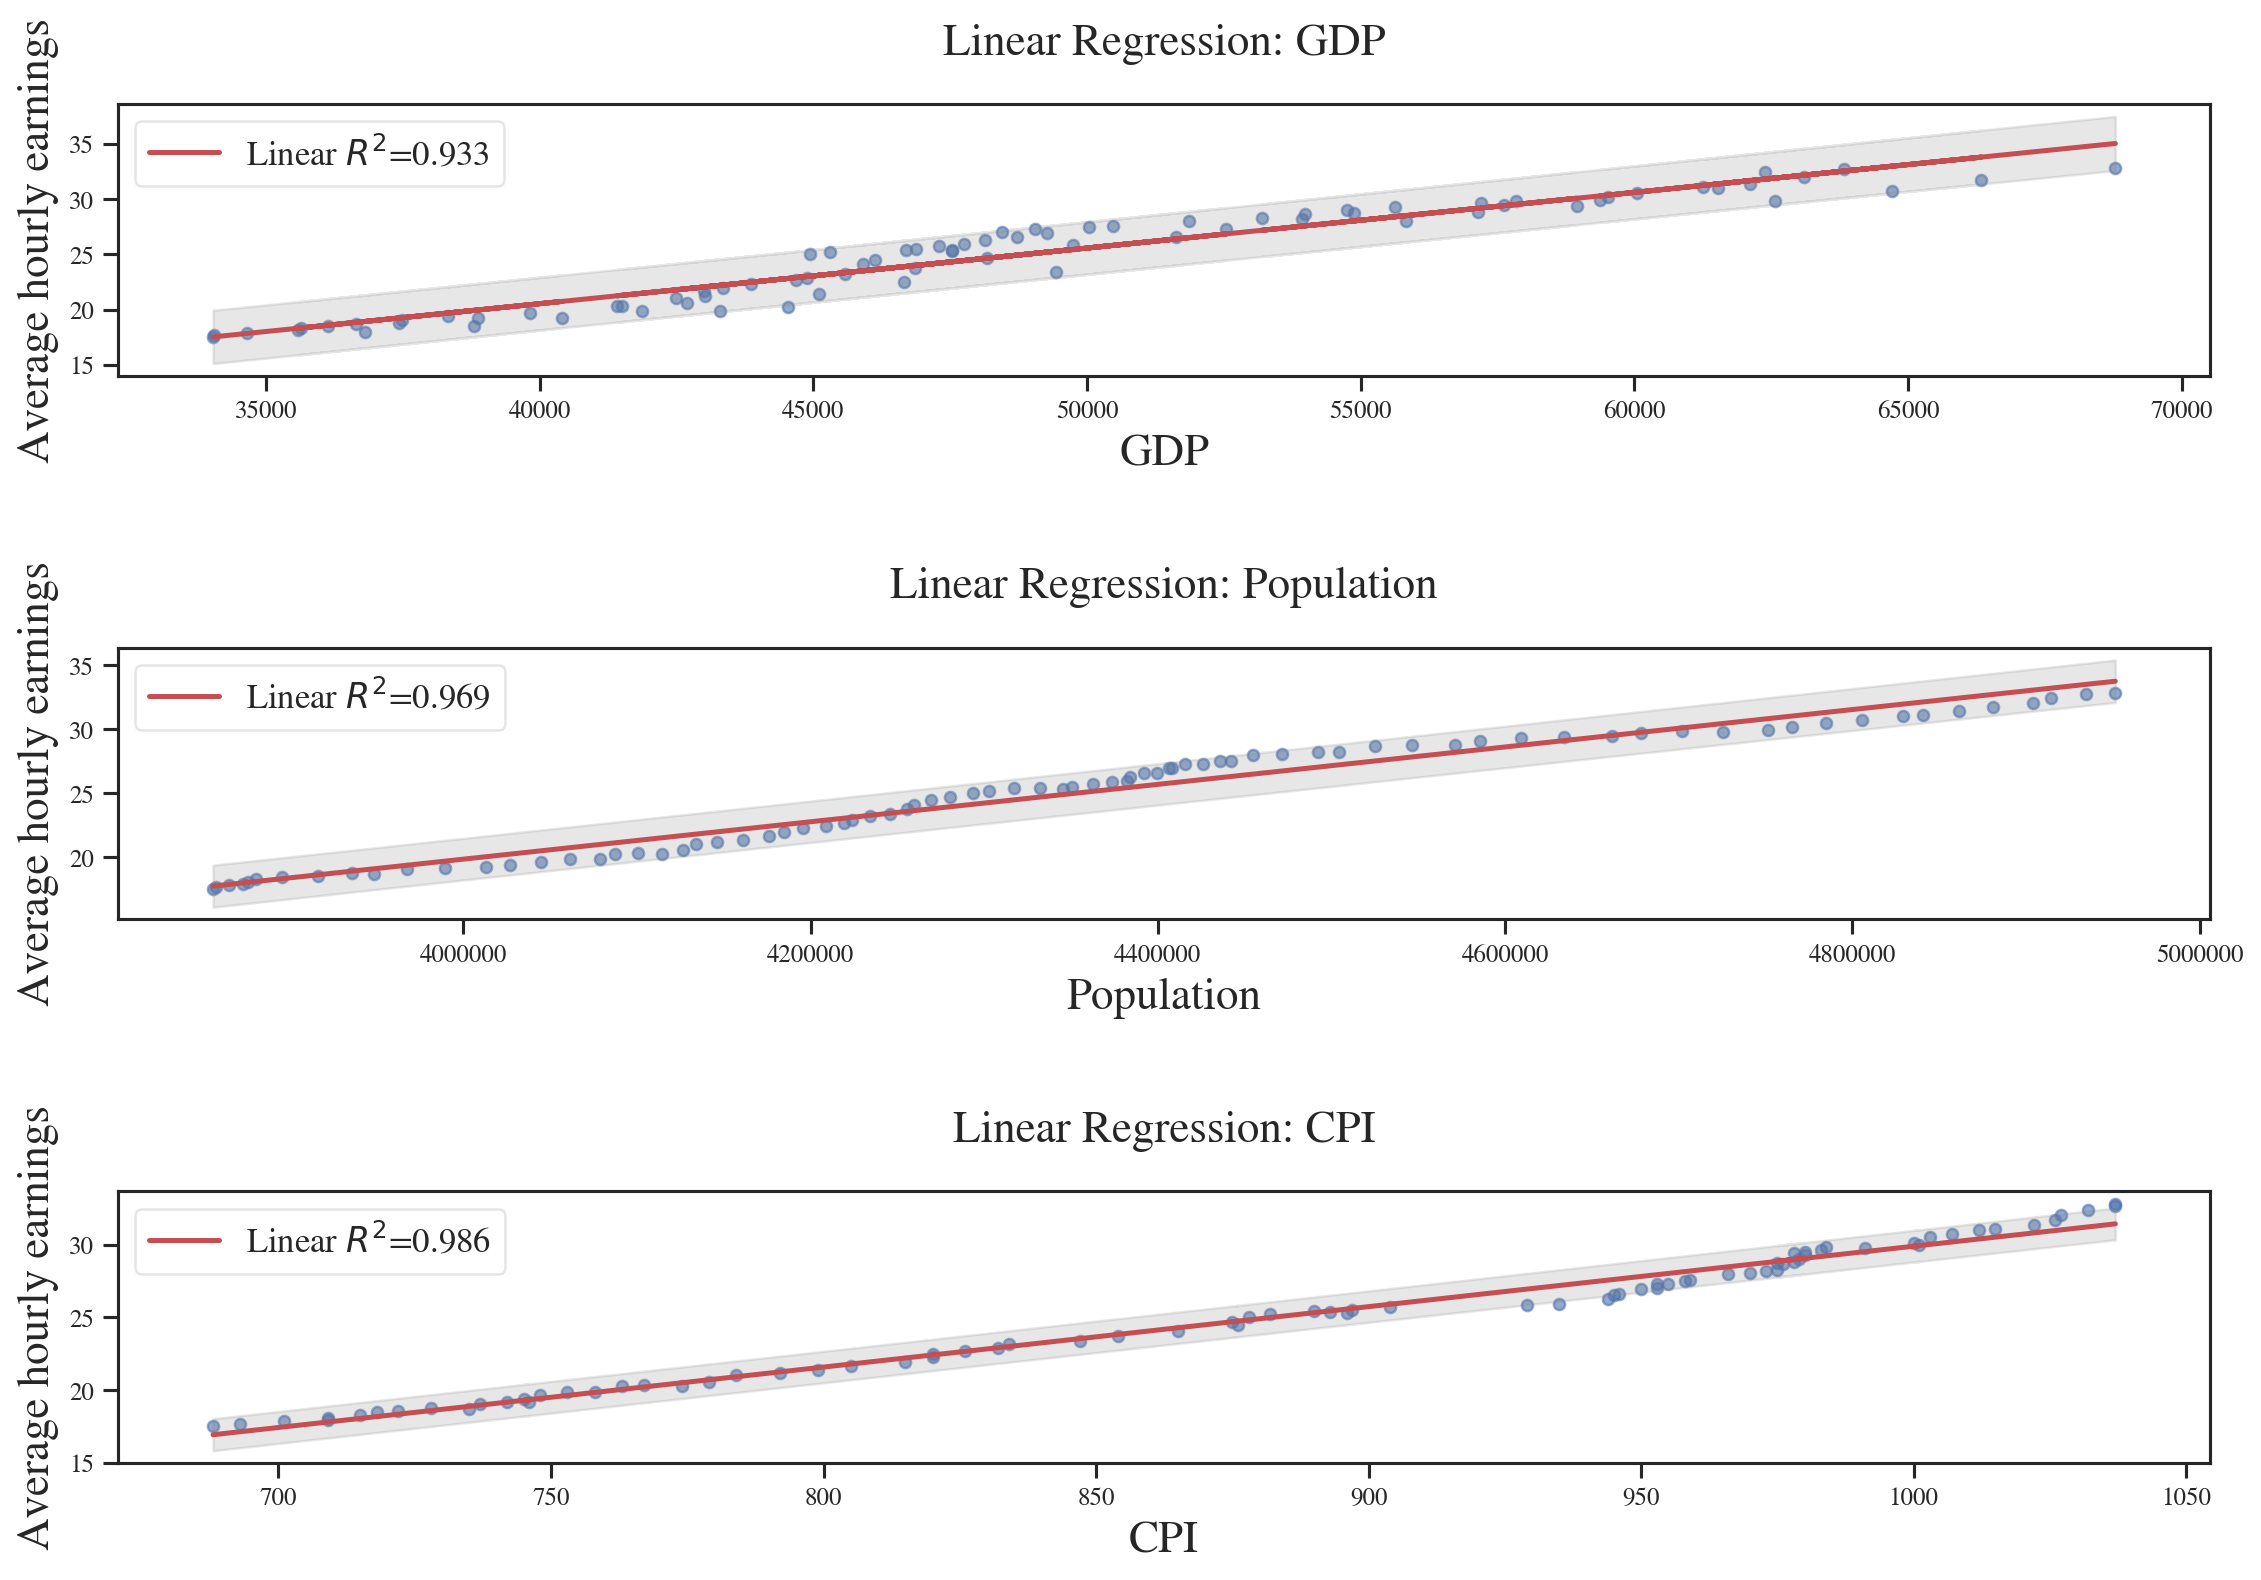

In [159]:
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, r2_score
# three features will be used as predictor
features = ['GDP', 'Population', 'CPI']
X = economy_table[features]
y = economy_table['Average hourly earnings']

fig, ax = plt.subplots(3, 1)
for i in range(3):
    name = features[i]
    mod_iter = smf.ols(formula=f"Q('Average hourly earnings') ~ 1 + {name}", data=economy_table).fit()
    sdev, lower, upper = wls_prediction_std(mod_iter, alpha=0.05)
    
    
    ax[i].scatter(economy_table[name], economy_table['Average hourly earnings'], s=20, alpha=0.6)
    ax[i].plot(economy_table[name], mod_iter.predict(economy_table[name]), \
               'r-', label=f'Linear $R^2$={mod_iter.rsquared:.3f}')
    ax[i].fill_between(economy_table[name], lower, upper, color='#888888', alpha=0.2)
    
    ax[i].legend(loc='upper left', framealpha=0.5, prop={'size':'x-small'})
    ax[i].set_title(f'Linear Regression: {name}', fontdict={'fontsize':18}, pad=20)
    ax[i].set_xlabel(f'{name}', fontdict={'fontsize':18})
    plt.subplots_adjust( hspace=1)
    ax[i].set_ylabel('Average hourly earnings', fontdict={'fontsize':18})


The results show **perfect $R^2$ score**. If we consider those models, all the three features are highly credible for predict our incomes.

we can also try Linear Regression based the other two features.

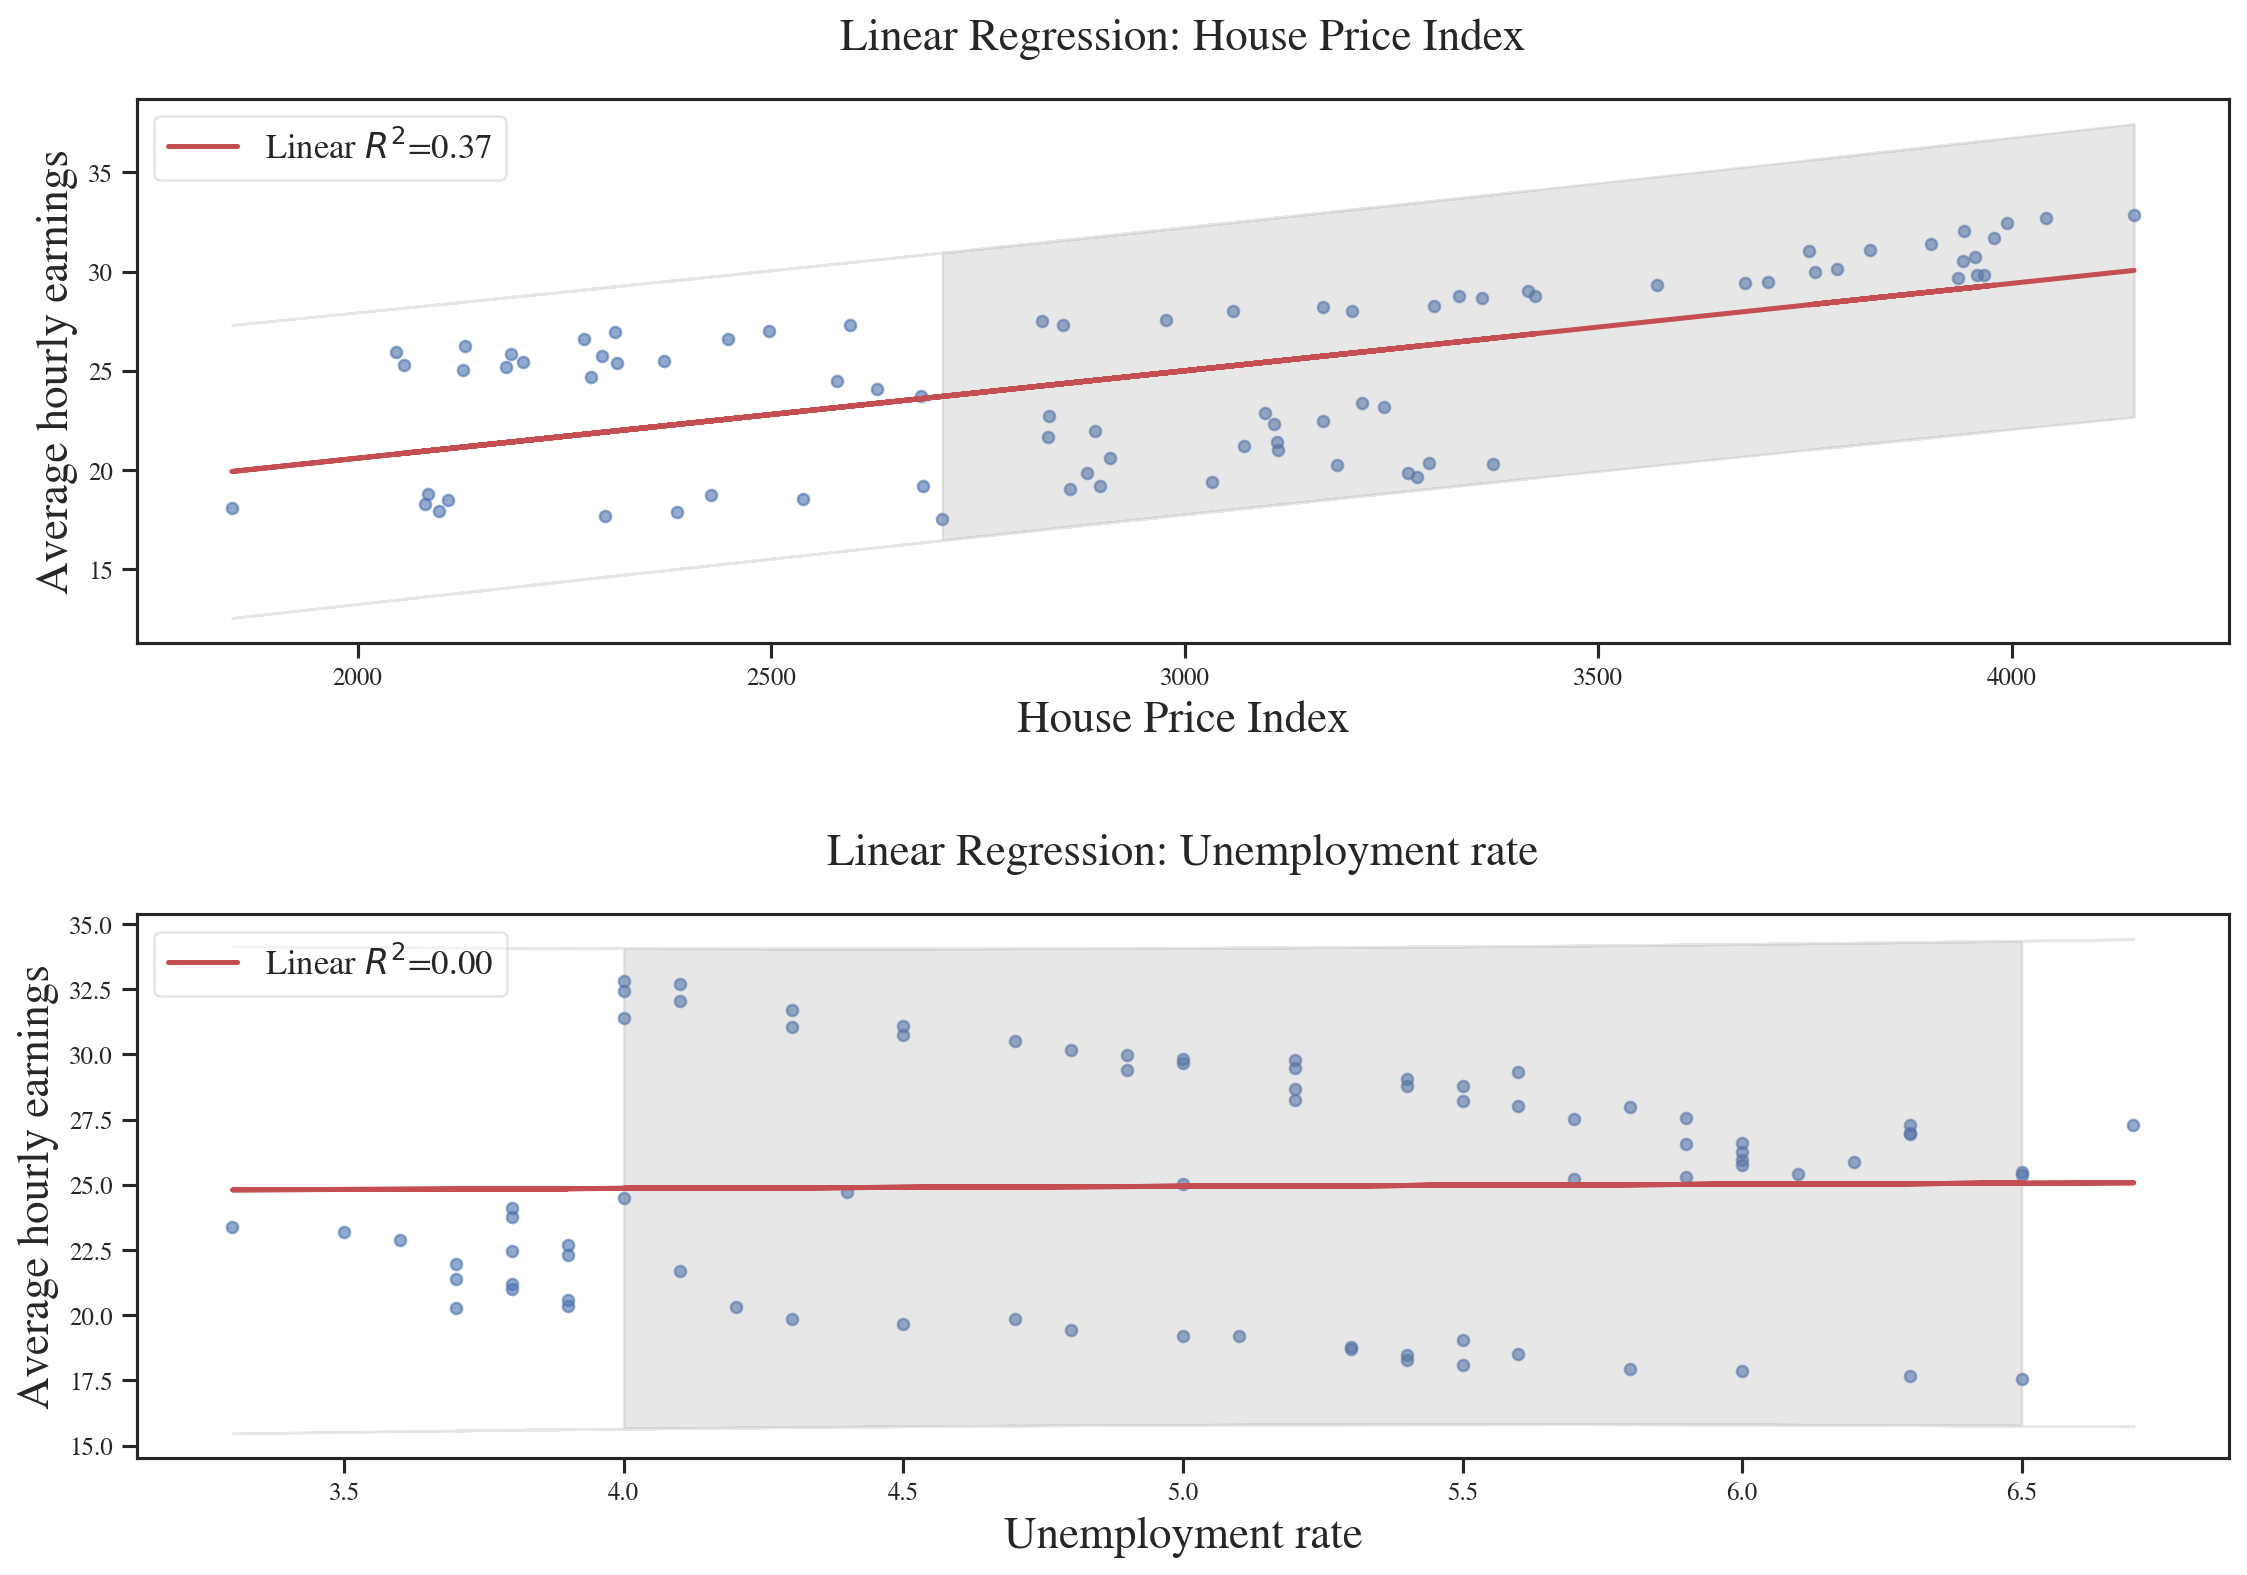

In [160]:
# the other two features will be used as predictor
feature_others = ['House Price Index', 'Unemployment rate']
fig, ax = plt.subplots(2, 1)

for i in range(2):
    name = feature_others[i]
    mod_other = smf.ols(formula=f"Q('Average hourly earnings') ~ 1 + Q('{name}')", data=economy_table).fit()
    sdev, lower, upper = wls_prediction_std(mod_other, alpha=0.05)
    ax[i].scatter(economy_table[name], economy_table['Average hourly earnings'], s=20, alpha=0.6)
    ax[i].plot(economy_table[name], mod_other.predict(economy_table[name]), \
               'r-', label=f'Linear $R^2$={mod_other.rsquared:.2f}')
    ax[i].fill_between(economy_table[name], lower, upper, color='#888888', alpha=0.2)
    
    ax[i].legend(loc='upper left', framealpha=0.5, prop={'size':'x-small'})
    ax[i].set_title(f'Linear Regression: {name}', fontdict={'fontsize':18}, pad=20)
    ax[i].set_xlabel(f'{name}', fontdict={'fontsize':18})
    ax[i].set_ylabel('Average hourly earnings', fontdict={'fontsize':18})
    plt.subplots_adjust( hspace=0.5)

The two charts show that the new Linear Regressions both have much lower $R^2$ than the other three features, so the two features can be considered as less valuable for predicting Average hourly earnings. For that reason, the next section will only use the three strong correlative features, namely GDP, Population and CPI.  

One important thing need to be clarified here is overfitting - the X used for training is the same used for prediction - as mentioned above. A more plausible method is to split the data into "train data", which is used for training, and "test data", which is used for validation.

#### Linear Regression: predict the future
We now try to separate the data into two groups: training data and test data. Since the data is Time Series dataset, we will try to use historical data to predict future data, which means, the time periods of training data are the earlier ones, and the test data are later ones.

In [161]:
features = ['GDP', 'Population', 'CPI']
X = economy_table[features]
y = economy_table['Average hourly earnings']
#seperate the dataset to training date and test data
X_train = X[:60]; X_test = X[60:]; y_train = y[:60]; y_test = y[60:]

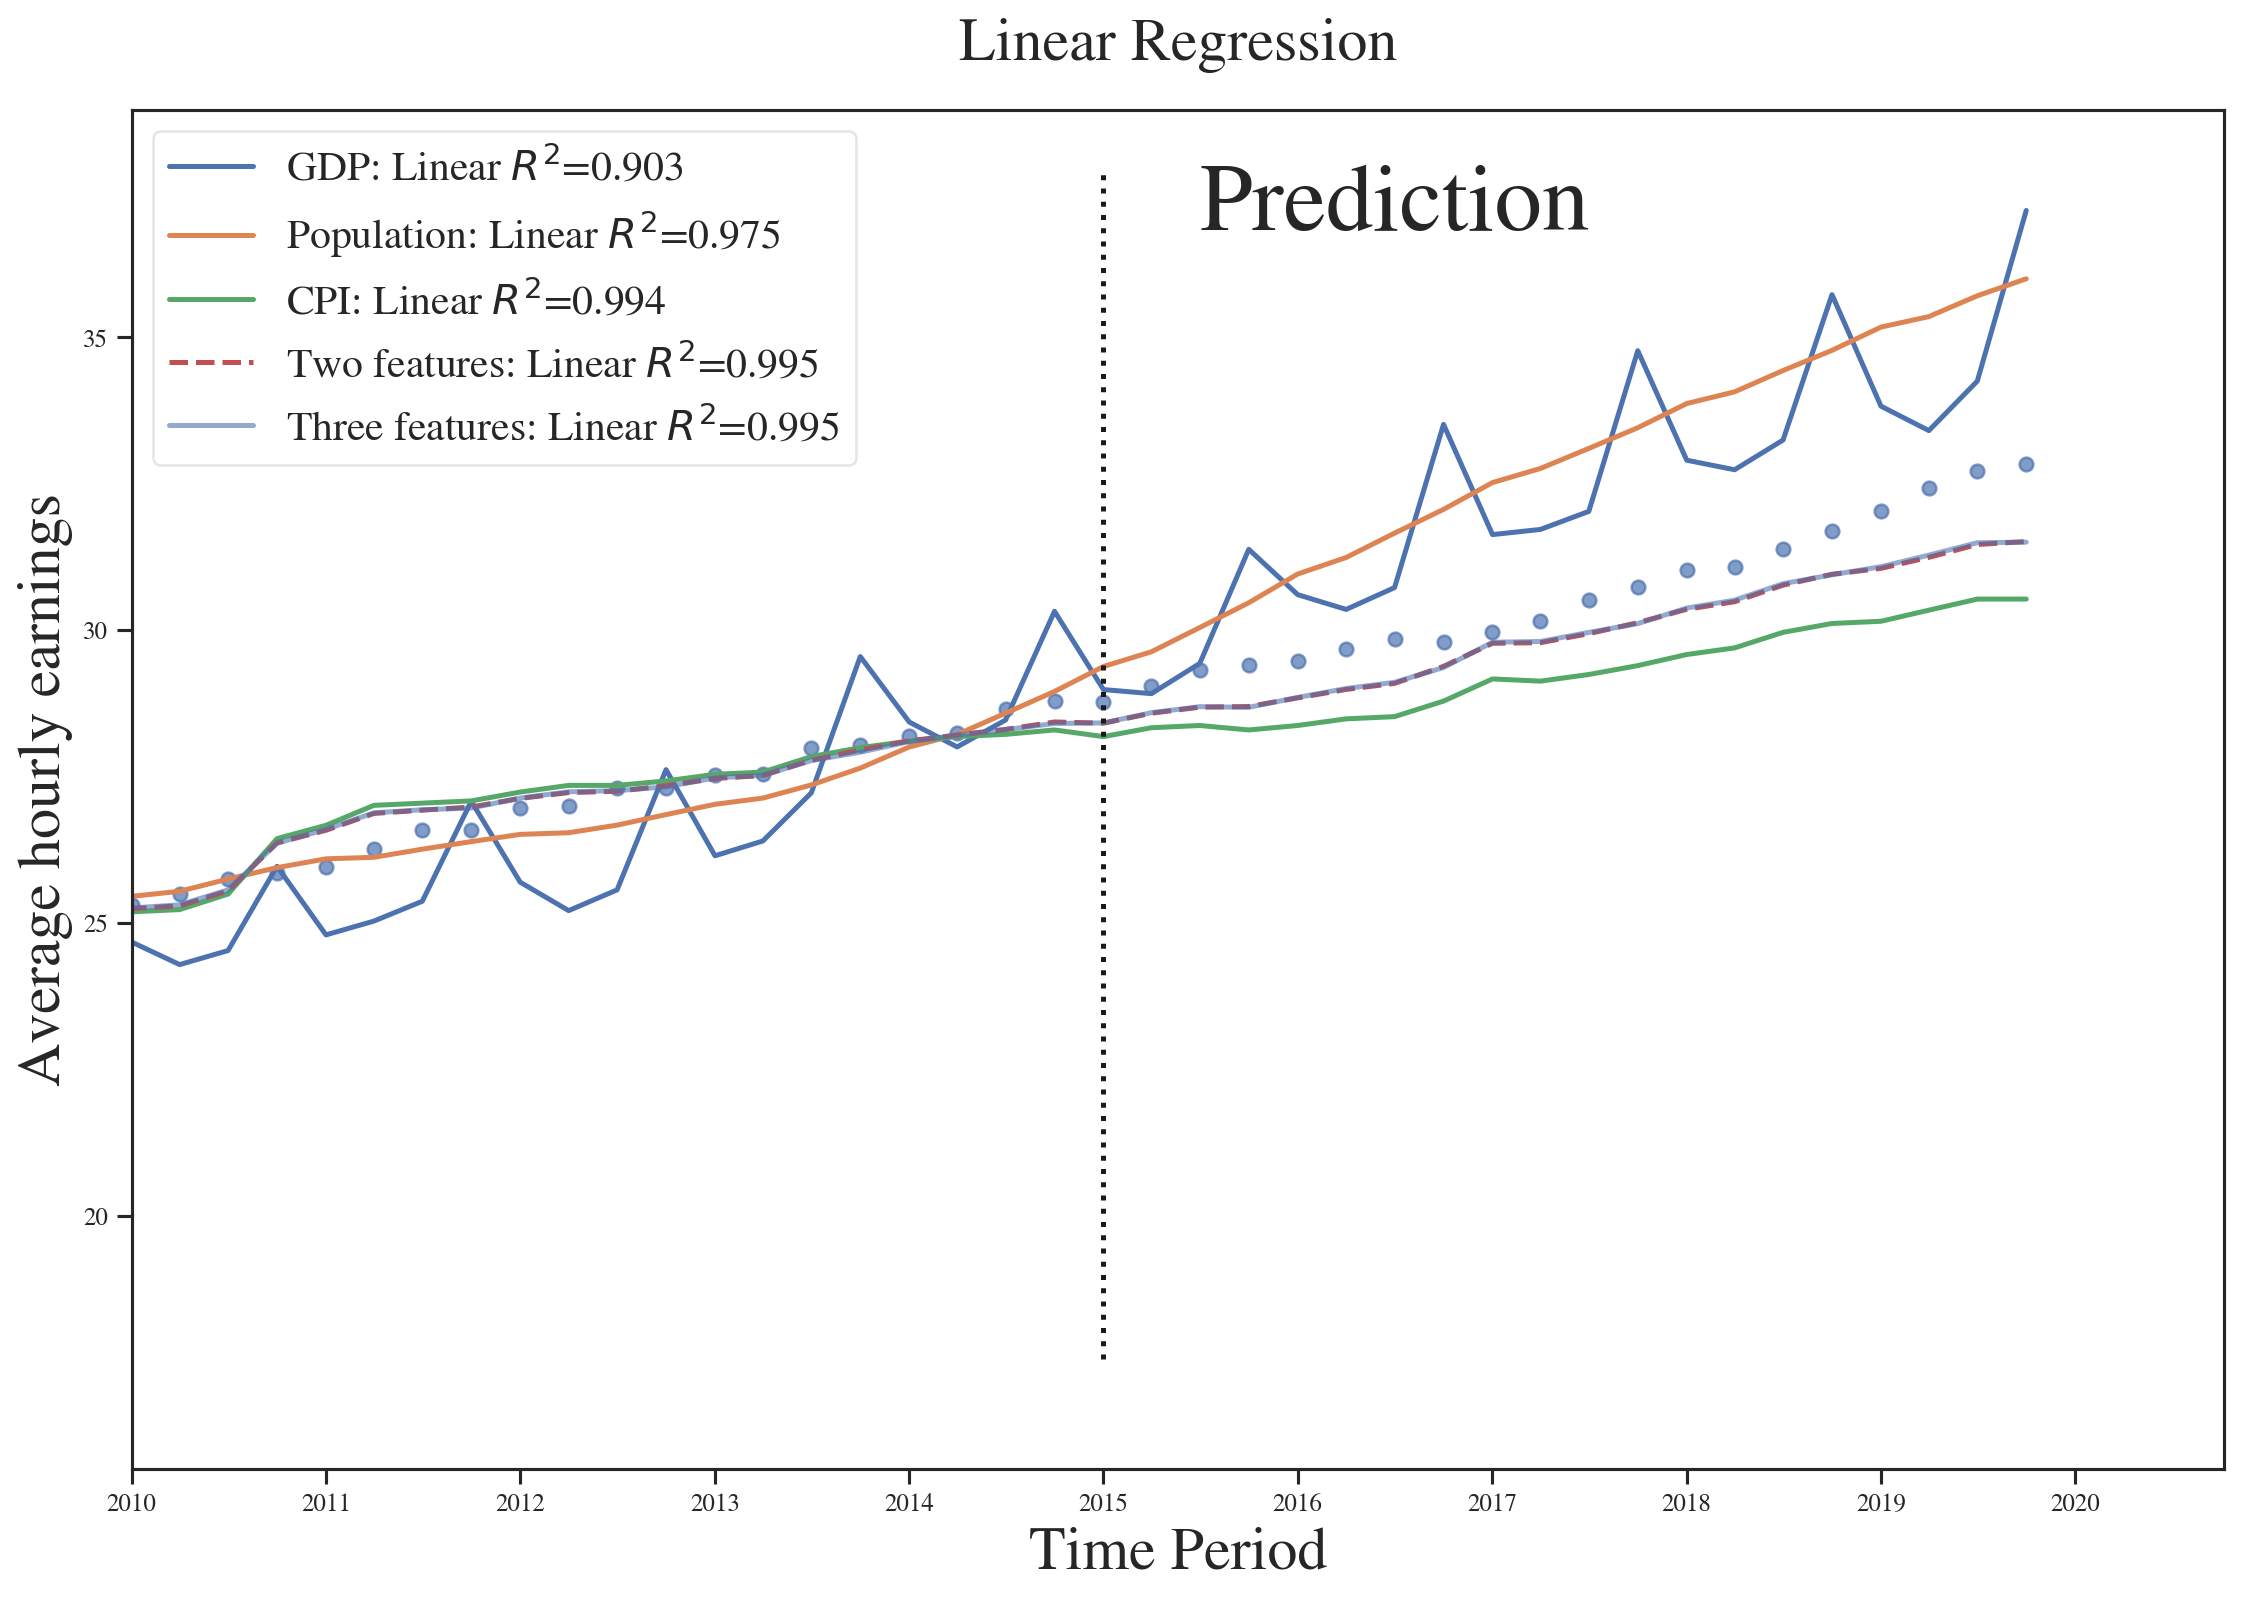

feature GDP, mean_absolute_error of prediction is: 1.7831117809718038
feature Population, mean_absolute_error of prediction is: 2.2374405089465035
feature CPI, mean_absolute_error of prediction is: 1.3356488955141992
feature Population + CPI, mean_absolute_error of prediction is: 0.6883527043996809
feature GDP + Population + CPI, mean_absolute_error of prediction is: 0.6770594482474651


In [164]:
## build models with single feature 
#MAE = mean absolute error, a dict to store all regressions' mae
MAE = {}
for i in range(3):
    name = features[i]
    mod_iter = smf.ols(formula=f"Q('Average hourly earnings') ~ 1 + {name}", data=economy_table[:60]).fit()
    predict_1f = mod_iter.predict(X[name])
    #linear regression plotting
    sns.lineplot(X.index, predict_1f, \
                label=f'{name}: Linear $R^2$={mod_iter.rsquared:.3f}')
    MAE[name] = mean_absolute_error(mod_iter.predict(X_test), y_test)

#build models with two feature: Population & CPI 
mod_train_2f= smf.ols(formula="Q('Average hourly earnings') ~ Population + CPI", \
                    data=economy_table[0:60]).fit()
predict_2f = mod_train_2f.predict(X[['Population', 'CPI']])
MAE['Population + CPI'] = mean_absolute_error(mod_train_2f.predict(X_test[['Population', 'CPI']]), y_test)                                    

#build models with three feature: GDP & Population & CPI 
mod_train_3f = smf.ols(formula="Q('Average hourly earnings') ~ GDP + Population + CPI", \
                    data=economy_table[0:60]).fit()
predict_3f = mod_train_3f.predict(X)
MAE['GDP + Population + CPI'] = mean_absolute_error(mod_train_3f.predict(X_test), y_test)   

#ploting orignal data and predict data
plt.scatter(economy_table.index, economy_table['Average hourly earnings'], s=30, alpha=0.7)
plt.plot(X.index, predict_2f, 'r--', \
         label=f'Two features: Linear $R^2$={mod_train_2f.rsquared:.3f}')
plt.plot(X.index, predict_3f, 'b-', \
         label=f'Three features: Linear $R^2$={mod_train_3f.rsquared:.3f}', alpha=0.6)


plt.legend(loc='upper left', framealpha=0.5, prop={'size':'small'})
plt.xlabel('Time Period', fontdict={'fontsize':24})
plt.ylabel('Average hourly earnings', fontdict={'fontsize':24})
plt.title(f'Linear Regression', fontdict={'fontsize':24}, pad=20)
plt.xlim(left=X.index[40])
plt.plot([economy_table[60:61].index] * 2, [np.min(y), np.max(y)+5], 'k:')
plt.annotate("Prediction", (economy_table[62:63].index, np.max(y)+4 ), fontsize=38)
plt.show()

for key, value in MAE.items():
    print(f'feature {key}, mean_absolute_error of prediction is: {value}')

it seems that feature CPI is the most correlative for predicting Average hourly earnings as the MAE score (= 1.34) is the smallest one among all single features Linear Regression. Based on the MAE values, however, it seems that more features involve, more accurate the model is (MAE = 0.68). 

**Notice: the X-axis is not any of the features but the Time Period (date).**

In the next sections, **All the three features will be used in the following Regression models, and the Linear Regression involving three features will used for comparison**.

### kNN Regression

In this section, we will try to use the kNN Algorithms to train data and predict "Average hourly earnings".

**Outliers identification**

Since all the features are in different scales, it is necessary to standardise and normalise all the data. Before the operation, we can try to identify whether there are outlier data in the dataset.
As the describe() function shows the min, max and quantiles, we will use the 1.5IRQ rule to evaluate whether there are outliers in the dataset.

In [163]:
from scipy.stats import iqr
IRQ = economy_table.apply(iqr,rng=(25, 75))
IRQ_min = economy_table.apply(iqr, rng=(0, 25))
IRQ_max = economy_table.apply(iqr, rng=(75, 100))
# use the 1.5IRQ rule to identify the outliers
if (IRQ_min < 1.5 * IRQ).all():
    print("no low outlier")
if (IRQ_max < 1.5 * IRQ).all():
    print("no up outlier")

no low outlier
no up outlier


### kNN regression without Normalisation

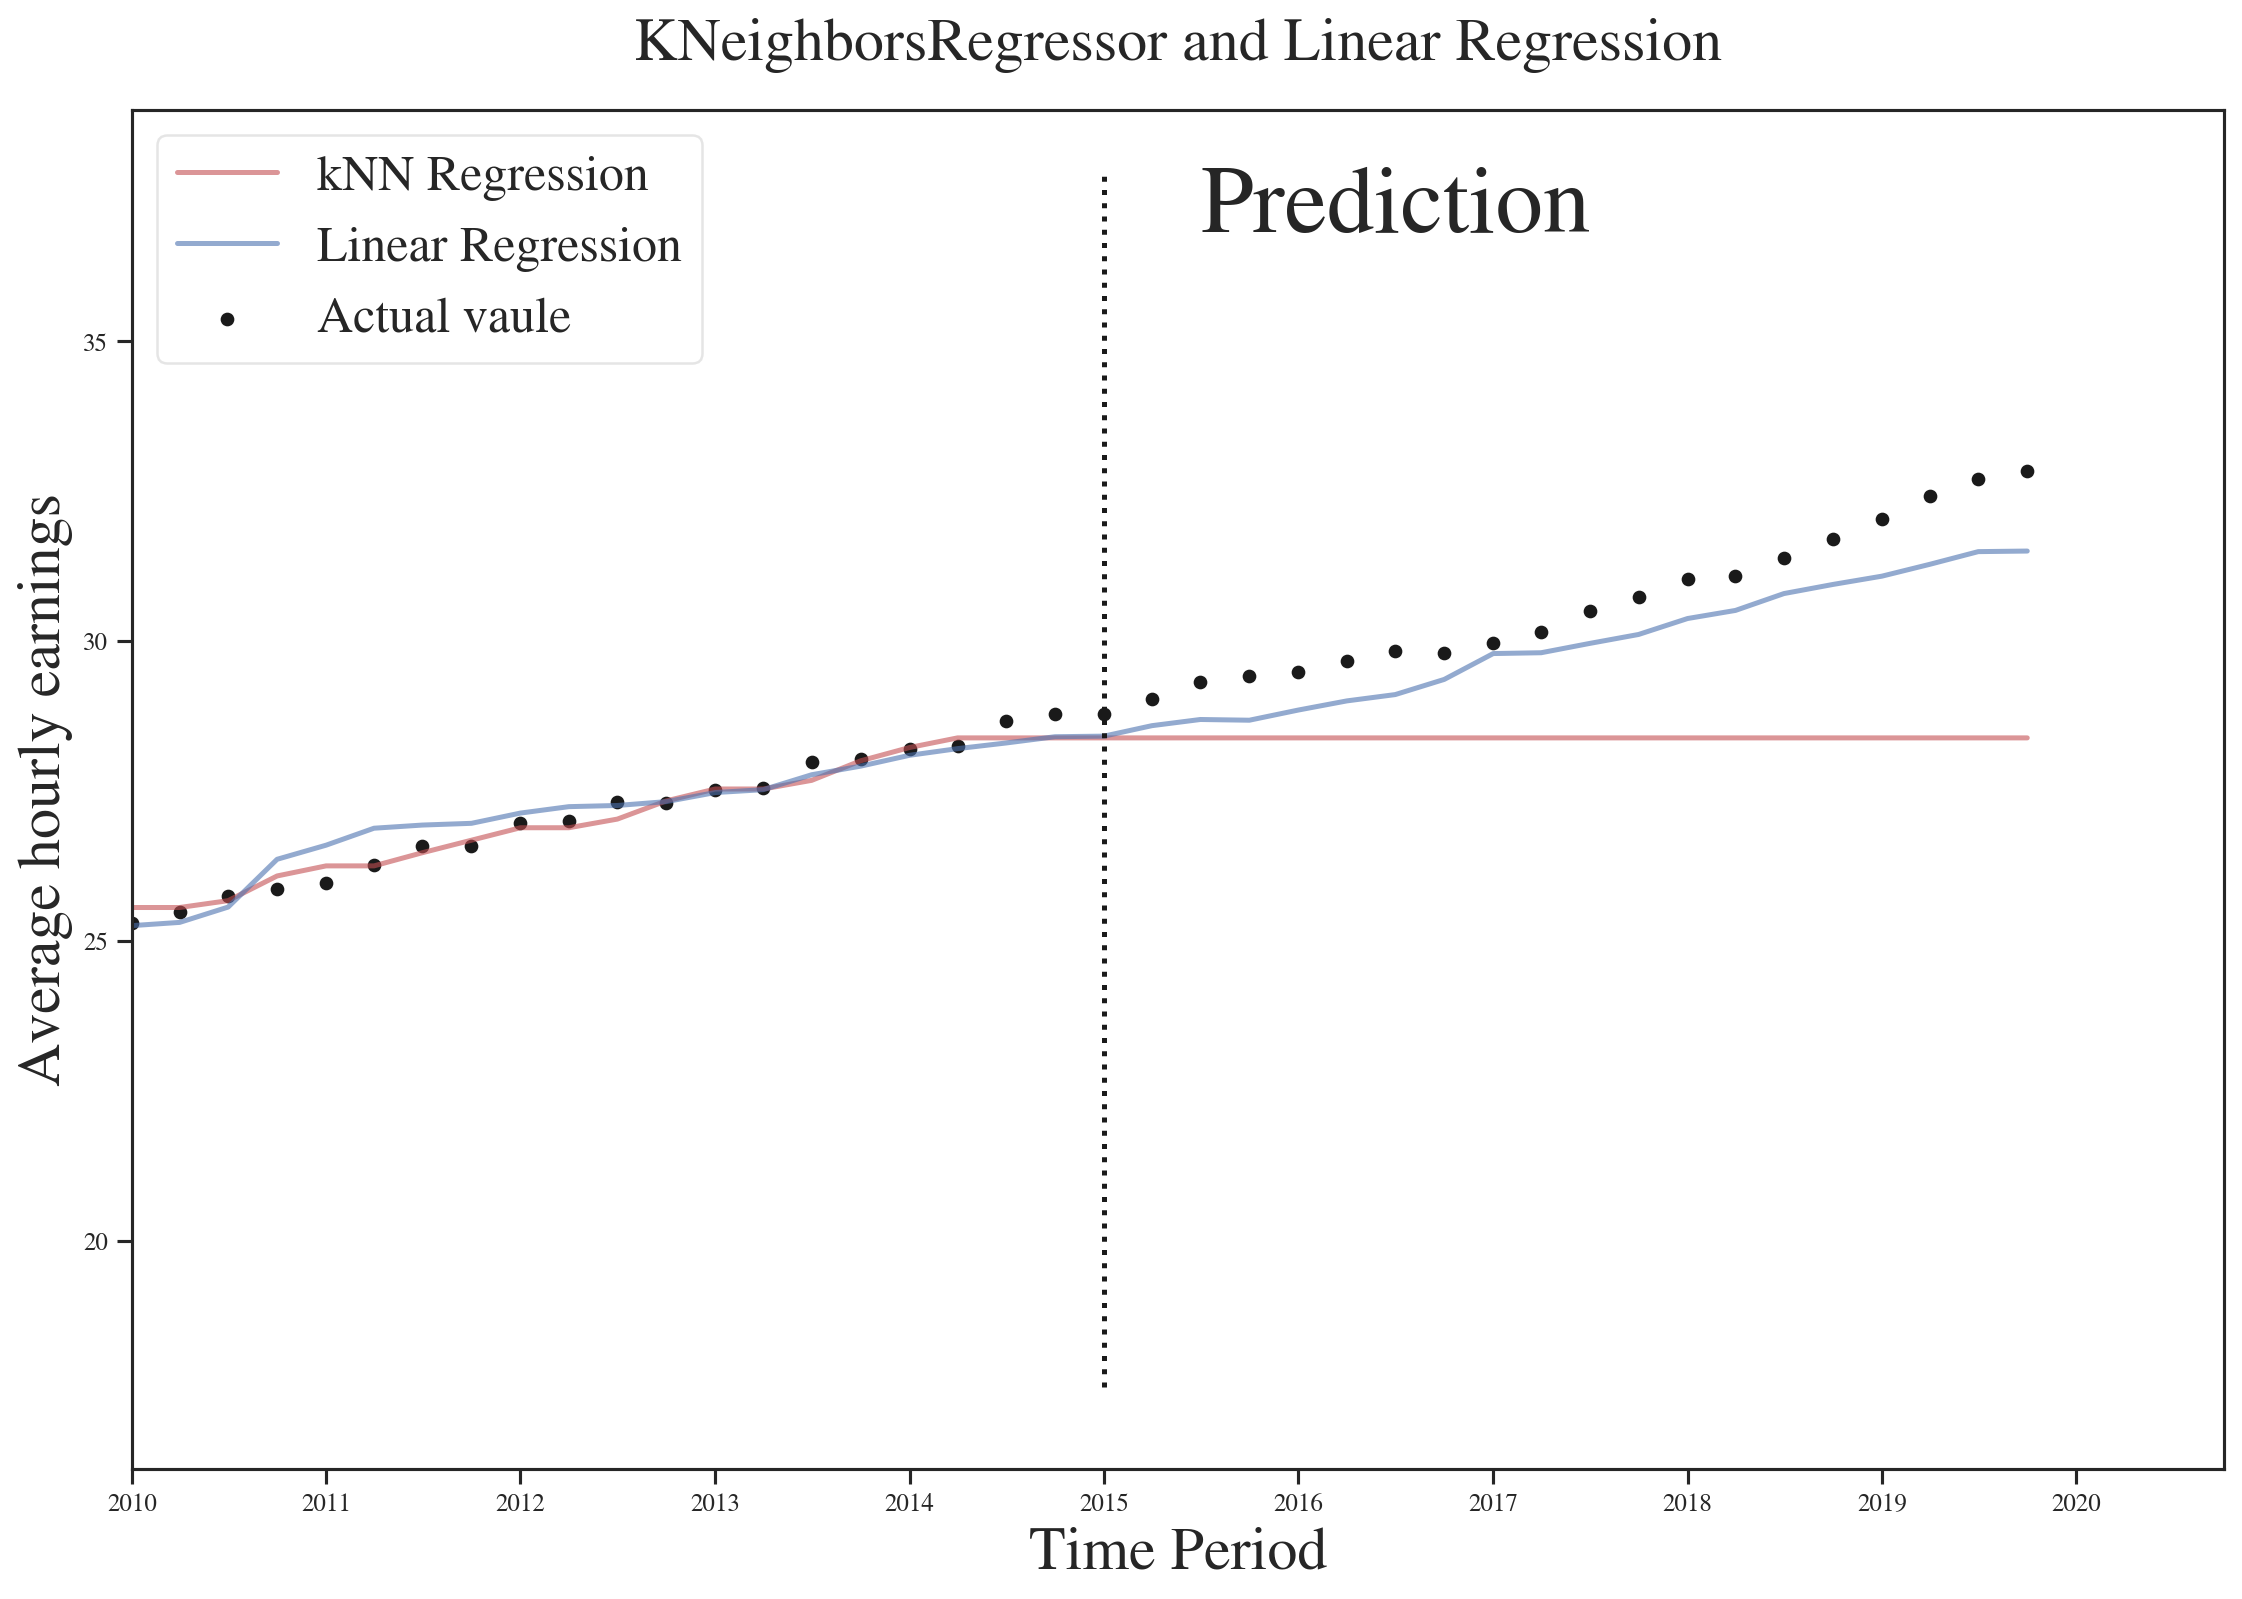

KNeighborsRegressor, mean absolute error of prediction is: 2.2084999999999972


In [165]:
from sklearn import neighbors 
# use three features to do the regression, and the label to predict is "Average hourly earnings"
#kNN model training & fit
neigh = neighbors.KNeighborsRegressor()
neigh.fit(X_train, y_train)
kNN_predict = neigh.predict(X)

#kNN predict data plotting, compaire with acutal data and Linear Regression
plt.plot(X.index, kNN_predict, 'r', label="kNN Regression", alpha=0.6)
plt.plot(X.index, predict_3f, 'b-', label=f'Linear Regression', alpha=0.6)
plt.scatter(y.index, y, label="Actual vaule", c='k', s=20)

plt.xlabel('Time Period', fontdict={'fontsize':24})
plt.ylabel('Average hourly earnings', fontdict={'fontsize':24})
plt.legend(loc='upper left', framealpha=0.5, prop={'size':'medium'})
plt.title('KNeighborsRegressor and Linear Regression', fontdict={'fontsize':24}, pad=20)
plt.xlim(left=X.index[40])
plt.plot([economy_table[60:61].index] * 2, [np.min(y), np.max(y)+5], 'k:')
plt.annotate("Prediction", (economy_table[62:63].index, np.max(y)+4 ), fontsize=38)
plt.show()
print("KNeighborsRegressor, mean absolute error of prediction is:", \
      mean_absolute_error(neigh.predict(X_test), y_test) )

The KNeighborsRegressor perform quite well in training data, but its performance on prediction is rather unreliable. One of the problems here may contribute to that all the features have different scale and magnitude. In the next section, we will try to use Z-score Normalisation to standardise the data and then evaluate the accuracy by computing MAE.

### Z-score Normalisation
Since the above results show no outliers, we could try to use the Z-score normalization method to standardise all three strong correlative features, and then apply kNN regression. It is helpful to compare the MAE between y_predict and y_test, and also plotting the outcomes of regressions on the same figure will get a more sensible conclusion.

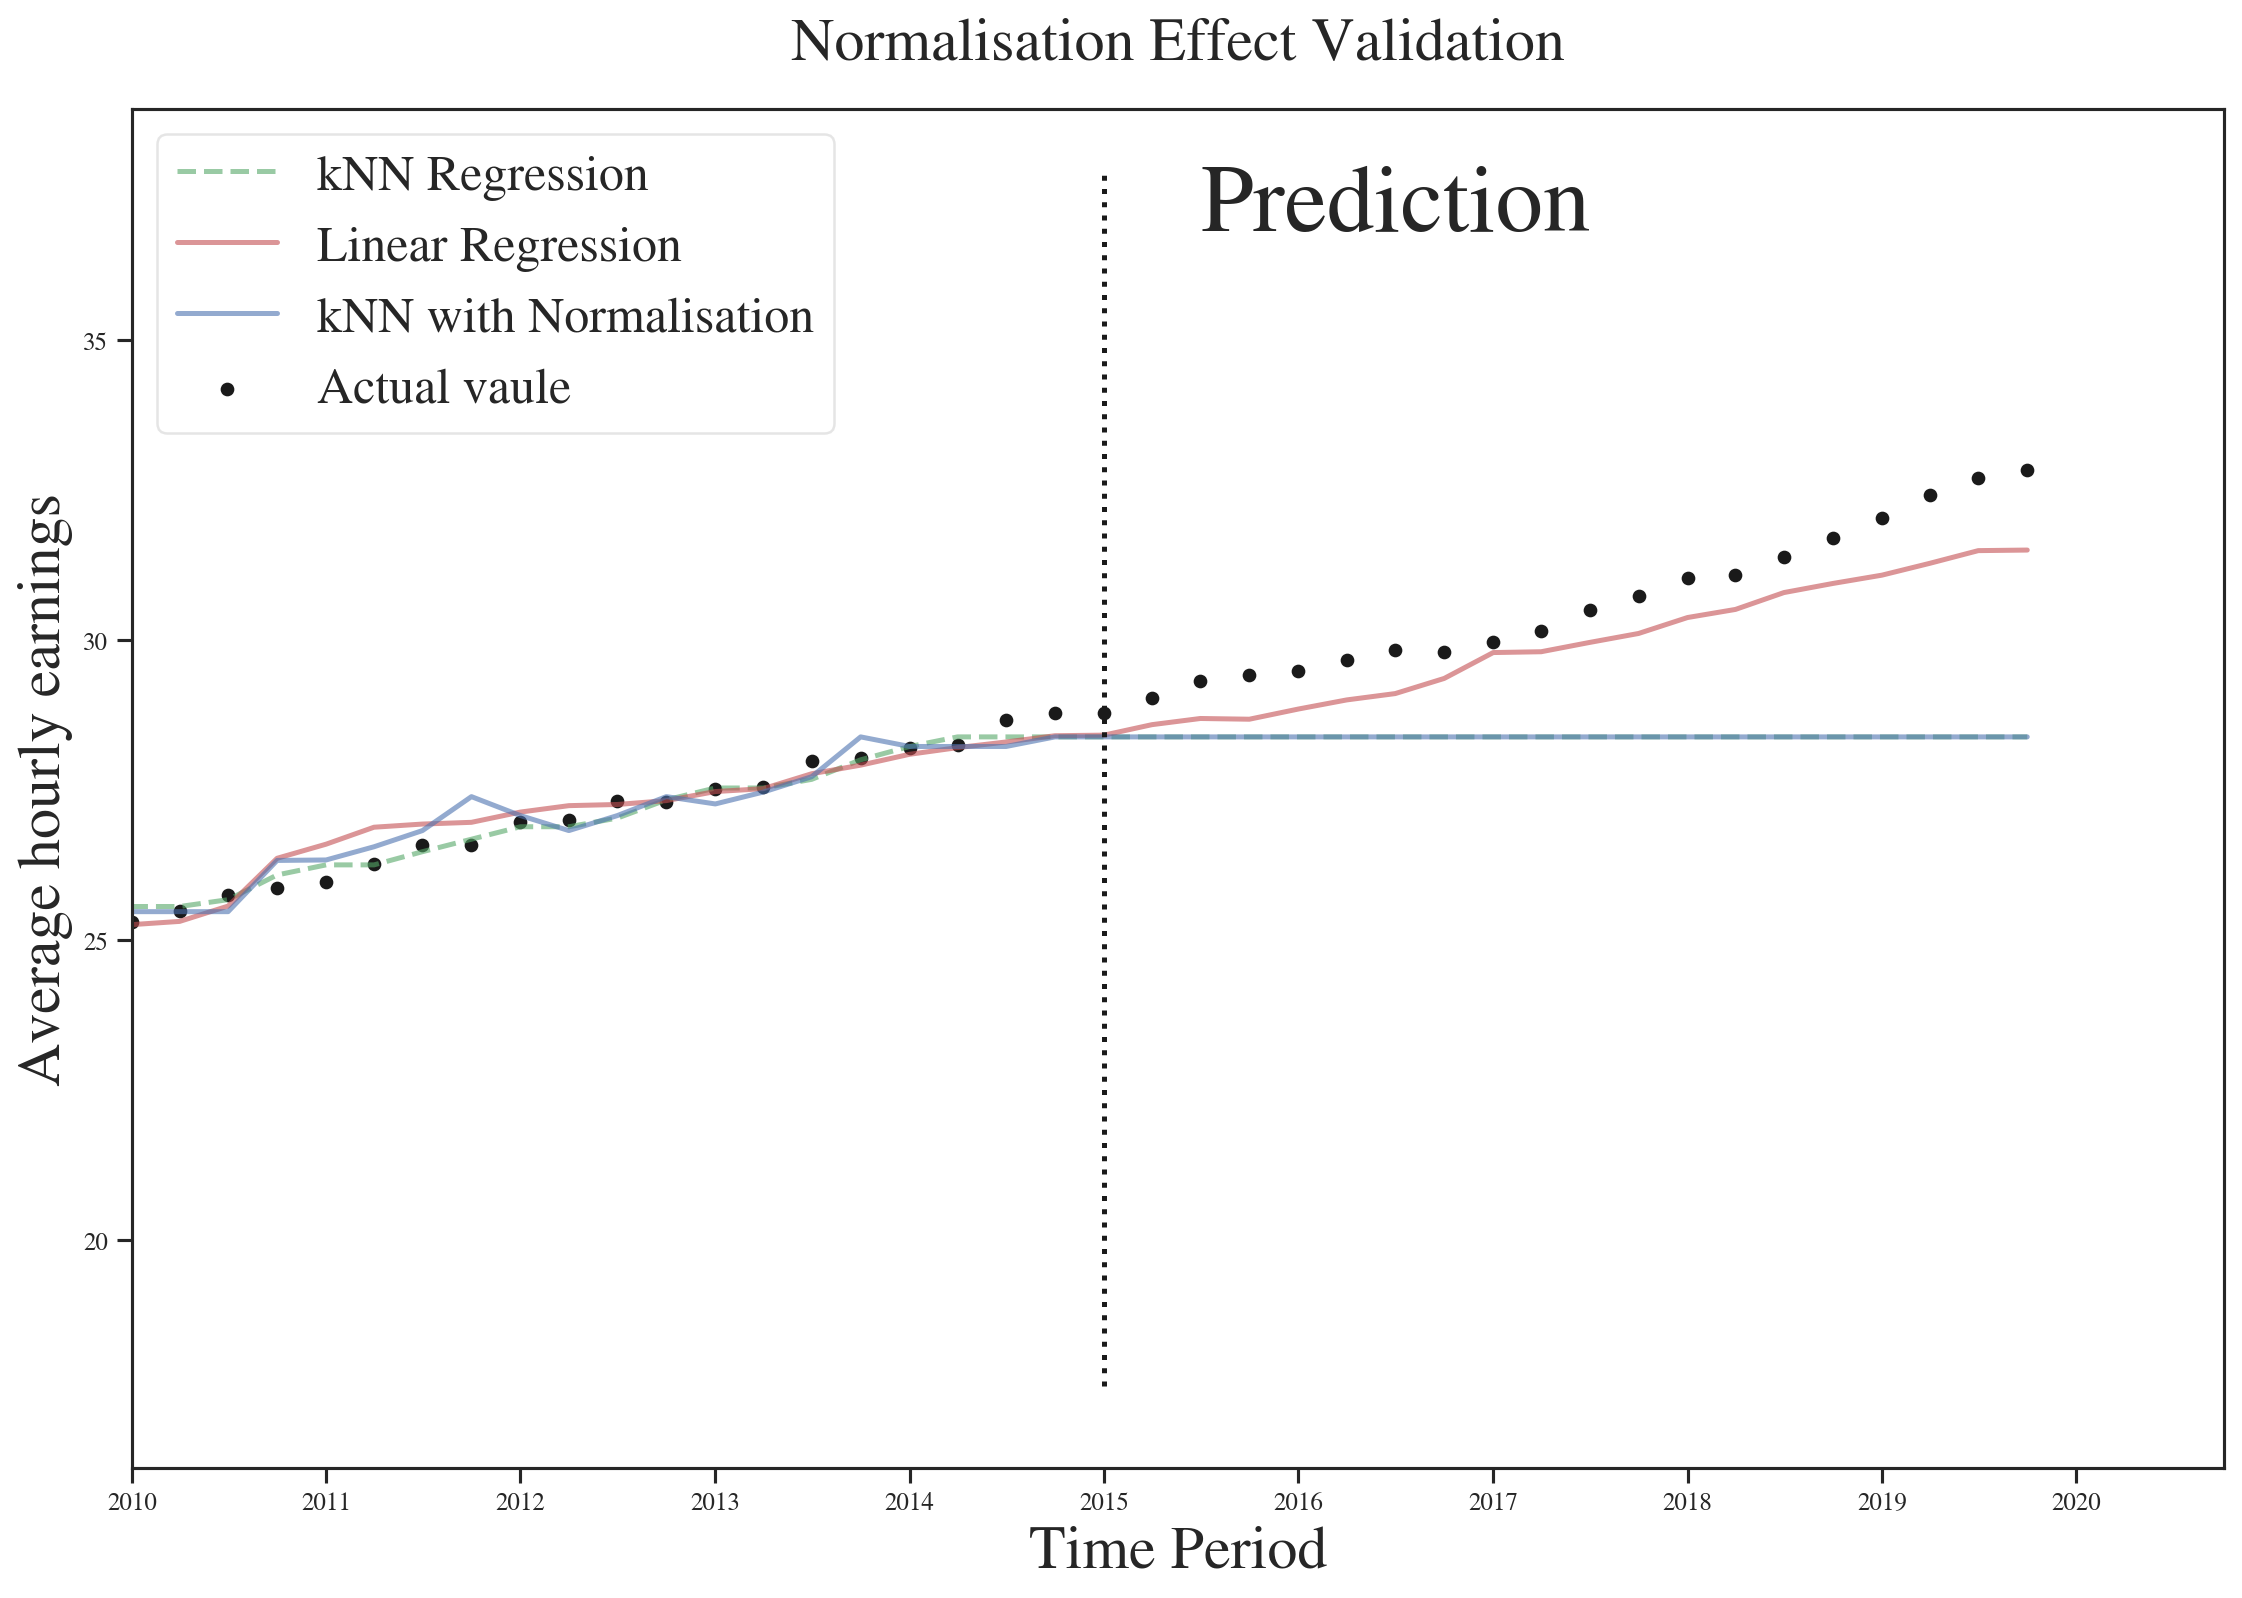

Normalised KNeighborsRegressor, mean absolute error of prediction is: 2.2084999999999972


In [168]:
from sklearn import preprocessing

# Z-score Normalisation the three features: GDP, Population, CPI
# notice that all the train data and test data are normalised
std_scale = preprocessing.StandardScaler().fit_transform(X, y)

#inherit the split pattern from the last section 
std_frame = pd.DataFrame(data=std_scale, index=economy_table.index, columns=features)
std_X_train = std_frame.loc[X_train.index]
std_X_test = std_frame.loc[X_test.index]

#kNN regression
std_neigh = neighbors.KNeighborsRegressor()
std_neigh.fit(std_X_train, y_train)
std_kNN_predict = std_neigh.predict(std_frame)

#data plotting
plt.plot(X.index, kNN_predict, 'g--', label="kNN Regression", alpha=0.6)
plt.plot(X.index, predict_3f, 'r', label=f'Linear Regression', alpha=0.6)
plt.plot(X.index, std_kNN_predict, 'b',label=f"kNN with Normalisation", alpha=0.6)
plt.scatter(y.index, y, label="Actual vaule", c='k', s=20)


plt.xlabel('Time Period', fontdict={'fontsize':24})
plt.ylabel('Average hourly earnings', fontdict={'fontsize':24})
plt.legend(loc='upper left', framealpha=0.5, prop={'size':'medium'})
plt.title('Normalisation Effect Validation', fontdict={'fontsize':24}, pad=20)
plt.xlim(left=X.index[40])
plt.plot([economy_table[60:61].index] * 2, [np.min(y), np.max(y)+5], 'k:')
plt.annotate("Prediction", (economy_table[62:63].index, np.max(y)+4 ), fontsize=38)
plt.show()

print("Normalised KNeighborsRegressor, mean absolute error of prediction is:", \
      mean_absolute_error(std_neigh.predict(X_test), y_test) )

# Conclusion
It is surprising that although normalisation makes a difference in prediction on training data, it has no impact on predicting on test data - both predictions have exactly the same low accuracy. The reason behind the result can be explained that the Average hourly earnings is constantly increasing over time, any new data will be out of the previous data range, thus it is unpredictable by the existing neighbours, regardless of normalisation.


So, which one is the most plausible Regression model for prediction? In this case, **Linear Regression (involves the three most correlative features) is the best**.

# Appendix - Random Forest
RandomForestRegressor has the same issue as KNeighborsRegressor for prediction.

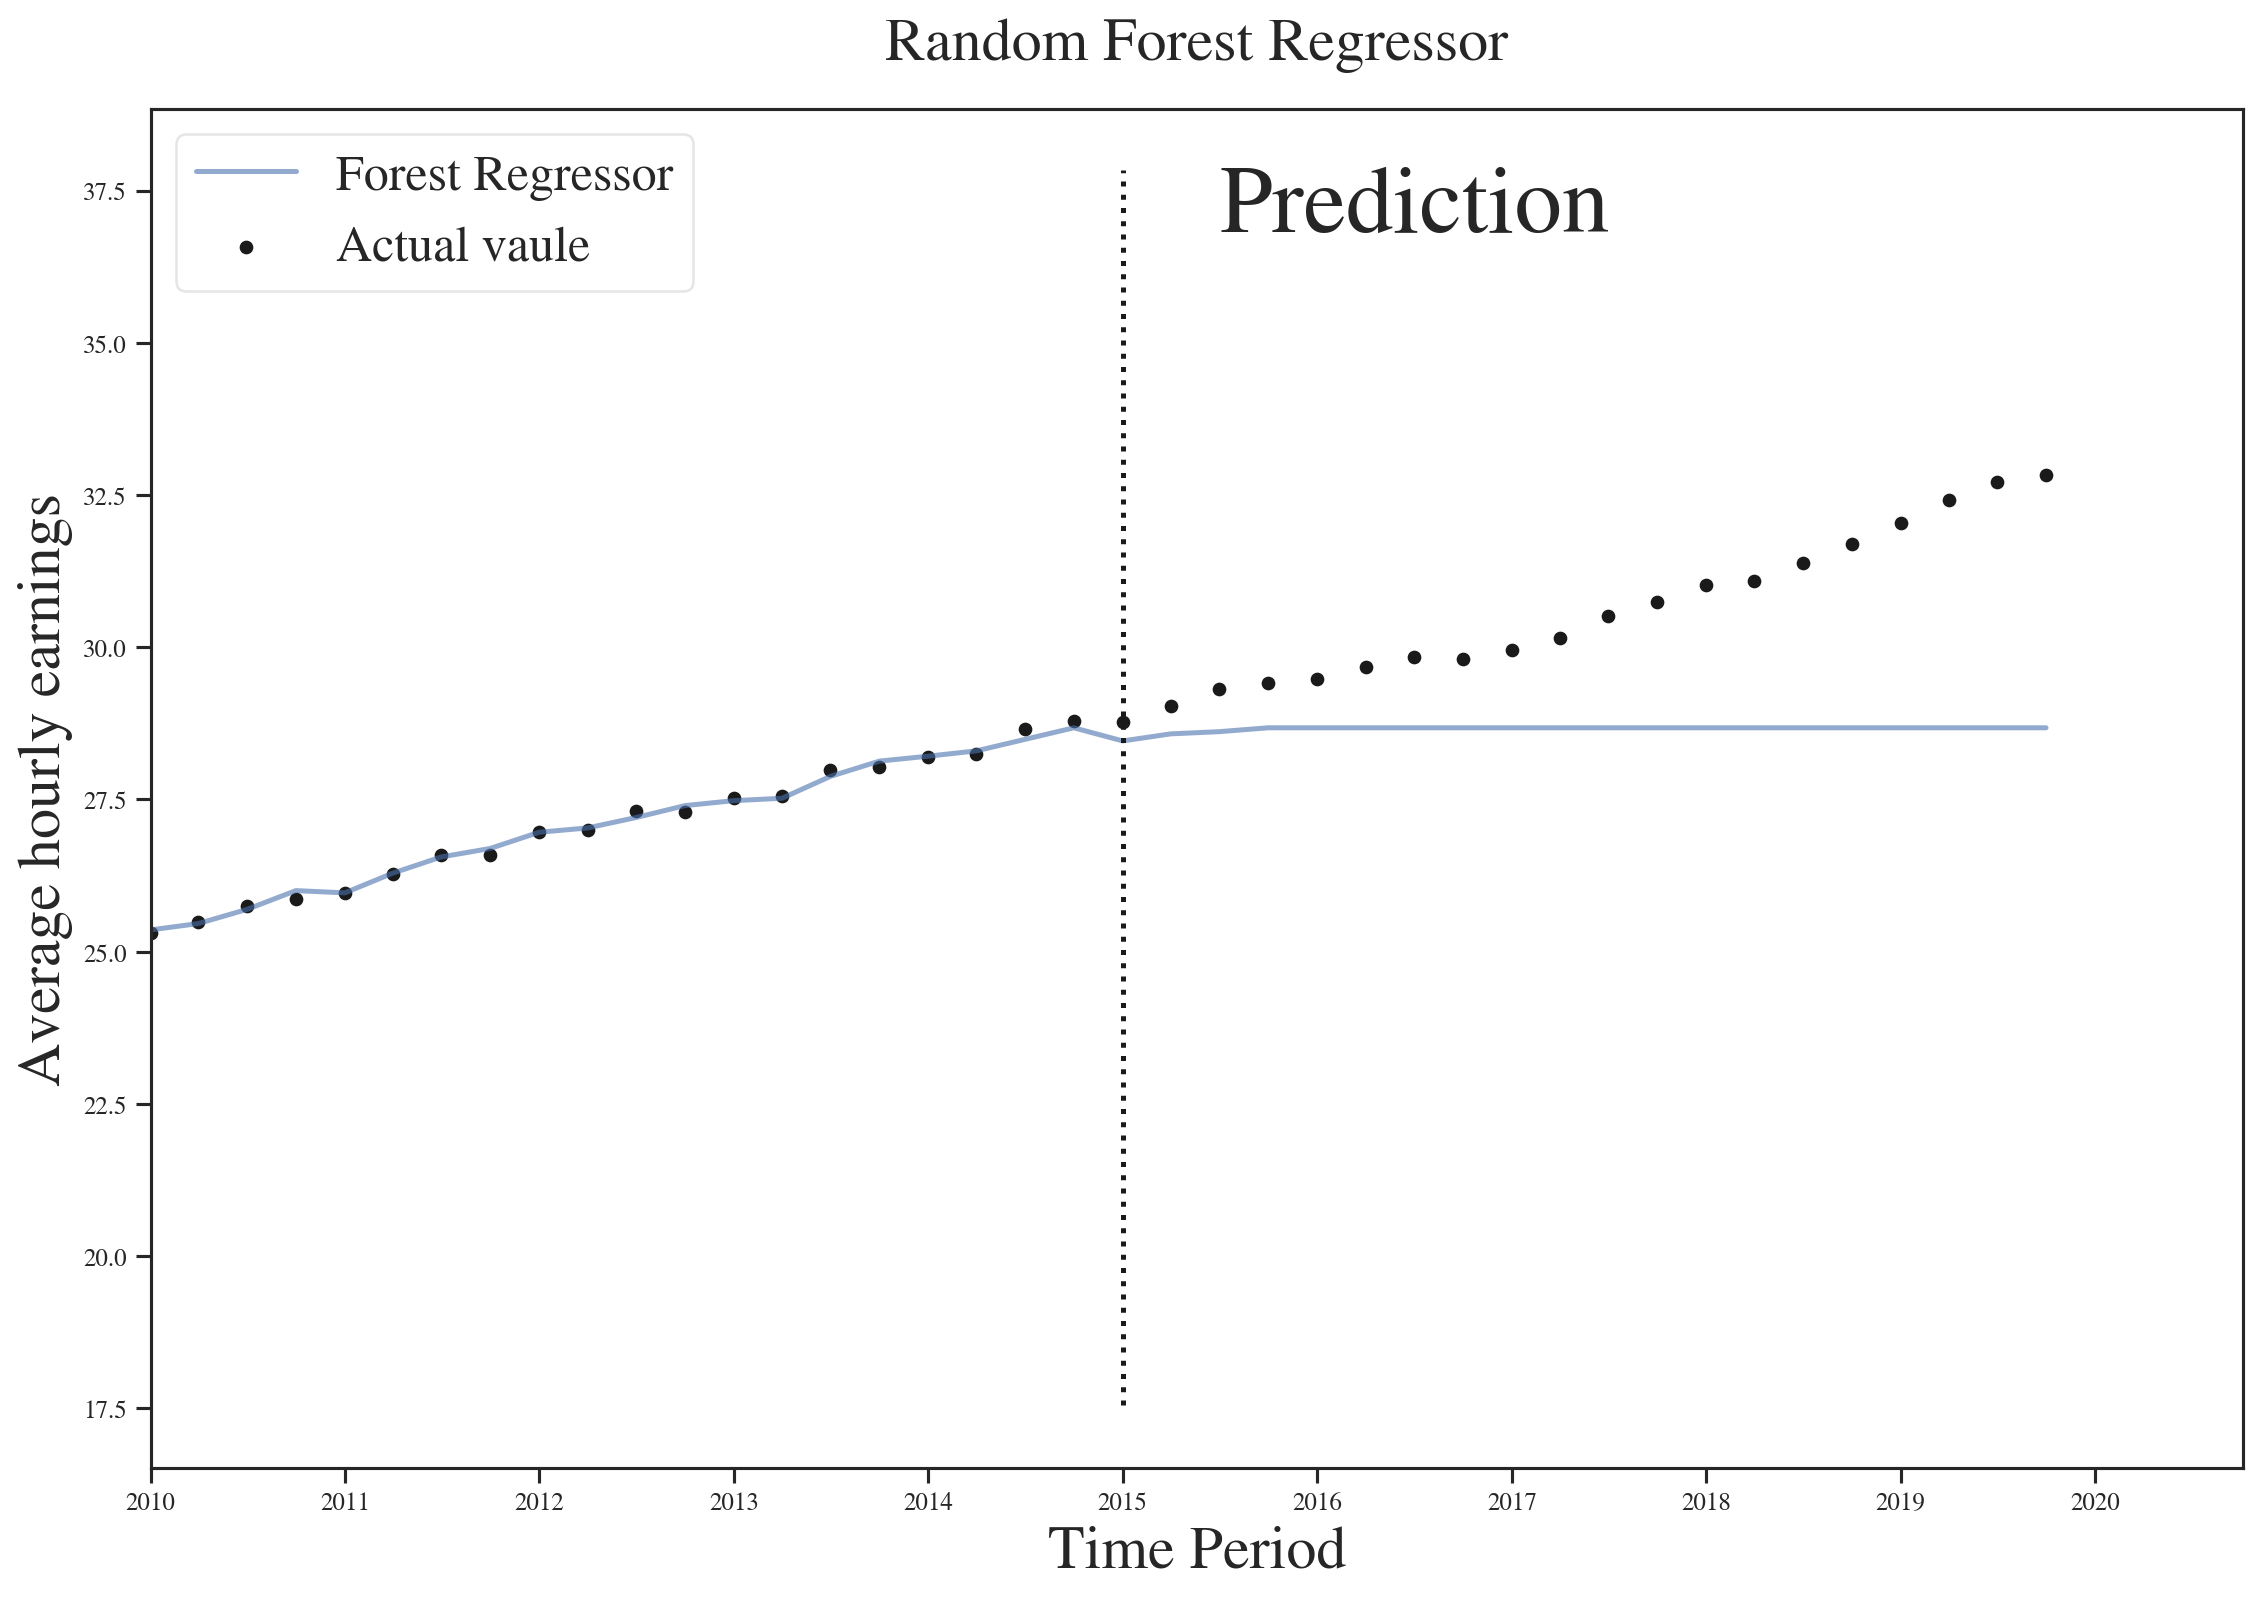

RandomForestRegressor mean absolute error of prediction is: 1.9363550000000174


In [167]:
from sklearn.ensemble import RandomForestRegressor
#build a Random Forest model with training data
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train, y_train)
forest_predict = forest_model.predict(X)


plt.plot(X.index, forest_predict, label=f"Forest Regressor", alpha=0.6)
plt.scatter(y.index, y, label="Actual vaule", c='k', s=20)

plt.xlabel('Time Period', fontdict={'fontsize':24})
plt.ylabel('Average hourly earnings', fontdict={'fontsize':24})
plt.legend(loc='upper left', framealpha=0.5, prop={'size':'medium'})
plt.title('Random Forest Regressor', fontdict={'fontsize':24}, pad=20)
plt.xlim(left=X.index[40])
plt.plot([economy_table[60:61].index] * 2, [np.min(y), np.max(y)+5], 'k:')
plt.annotate("Prediction", (economy_table[62:63].index, np.max(y)+4 ), fontsize=38)
plt.show()

print("RandomForestRegressor mean absolute error of prediction is:", \
      mean_absolute_error(forest_model.predict(X_test), y_test) )